In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
df = pd.read_csv("Exam_Score_Prediction.csv")


In [3]:
df.head()

,student_id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
0,1,17,male,diploma,2.78,92.9,yes,7.4,poor,coaching,low,hard,58.9
1,2,23,other,bca,3.37,64.8,yes,4.6,average,online videos,medium,moderate,54.8
2,3,22,male,b.sc,7.88,76.8,yes,8.5,poor,coaching,high,moderate,90.3
3,4,20,other,diploma,0.67,48.4,yes,5.8,average,online videos,low,moderate,29.7
4,5,20,female,diploma,0.89,71.6,yes,9.8,poor,coaching,low,moderate,43.7


In [4]:
df.columns

Index(['student_id', 'age', 'gender', 'course', 'study_hours',
       'class_attendance', 'internet_access', 'sleep_hours', 'sleep_quality',
       'study_method', 'facility_rating', 'exam_difficulty', 'exam_score'],
      dtype='object')

In [5]:
df.shape

(20000, 13)

In [6]:
df.isnull().sum()

student_id          0
age                 0
gender              0
course              0
study_hours         0
class_attendance    0
internet_access     0
sleep_hours         0
sleep_quality       0
study_method        0
facility_rating     0
exam_difficulty     0
exam_score          0
dtype: int64

<Axes: xlabel='study_method', ylabel='exam_score'>

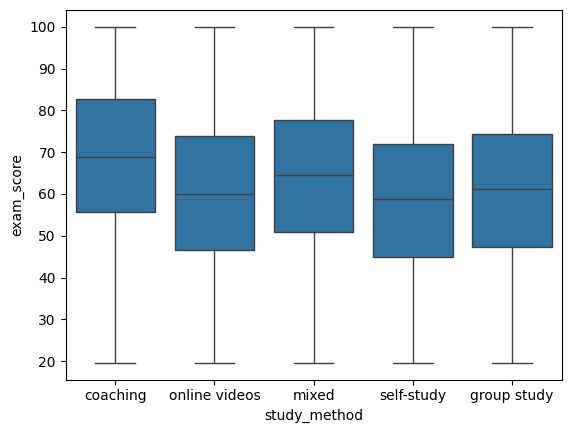

In [7]:
sns.boxplot(x='study_method', y='exam_score', data=df)

Text(0.5, 1.0, 'dependence of the grade on the difficulty of the exam')

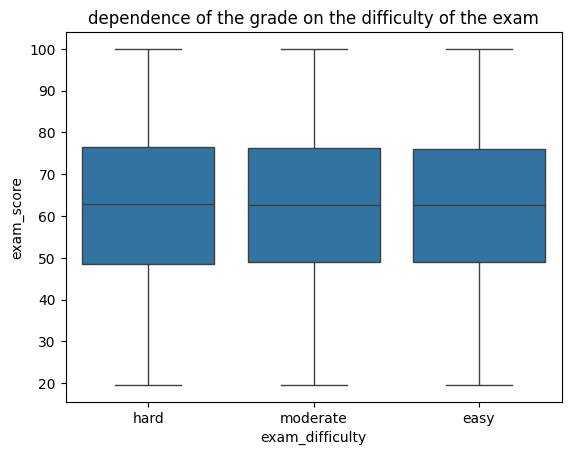

In [8]:
sns.boxplot(x='exam_difficulty', y='exam_score', data=df)
plt.title("dependence of the grade on the difficulty of the exam")

Text(0.5, 1.0, 'dependence of the grade on the study hours')

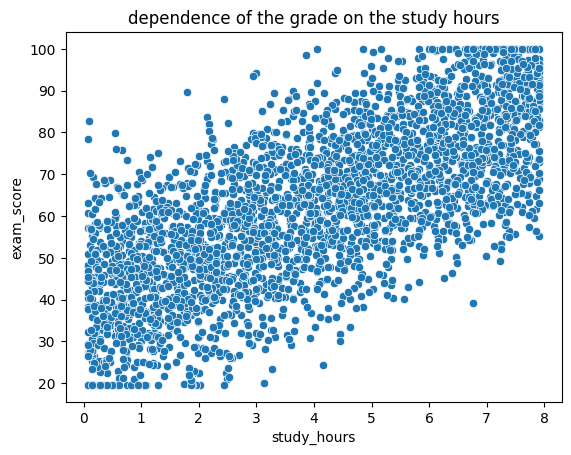

In [9]:
df_sample = df.sample(n=3000, random_state=42)

sns.scatterplot(
    x='study_hours',
    y='exam_score',
    data=df_sample
)
plt.title("dependence of the grade on the study hours")

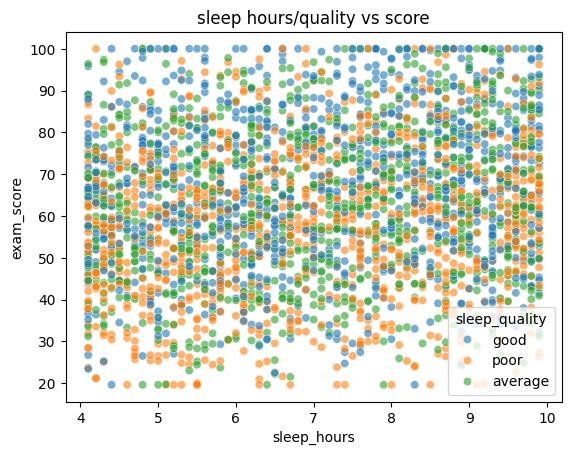

In [10]:
sns.scatterplot(
    x='sleep_hours',
    y='exam_score',
    hue='sleep_quality',
    data=df.sample(3000),
    alpha=0.6
)
plt.title("sleep hours/quality vs score")
plt.show()

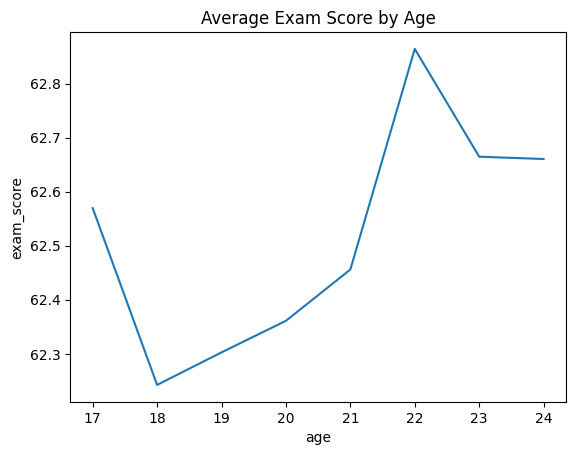

In [11]:
age_mean = df.groupby('age')['exam_score'].mean().reset_index()

sns.lineplot(
    x='age',
    y='exam_score',
    data=age_mean
)
plt.title("Average Exam Score by Age")
plt.show()

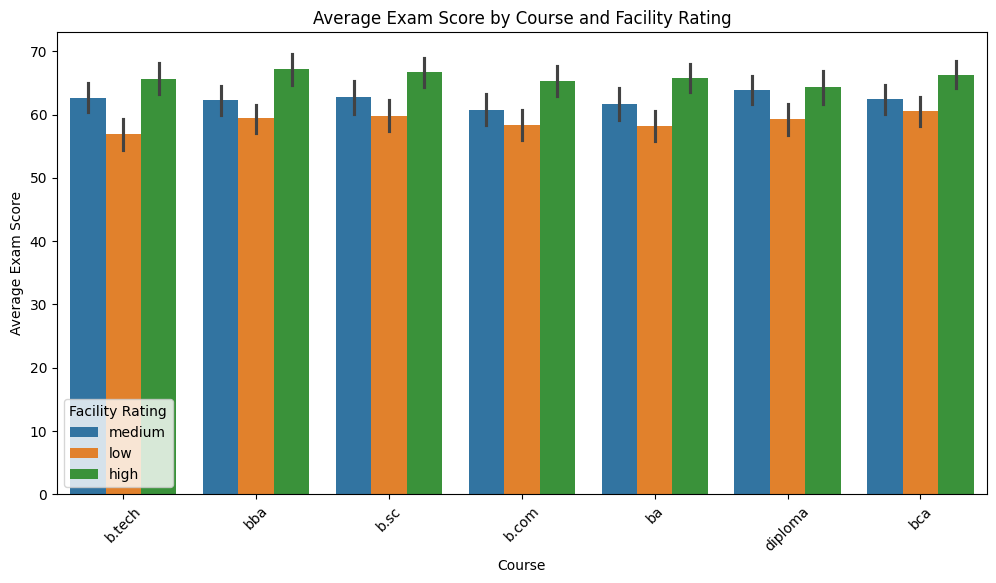

In [12]:
plt.figure(figsize=(12,6))
sns.barplot(
    x='course',
    y='exam_score',
    hue='facility_rating',
    data=df.sample(5000)
)
plt.xticks(rotation=45)
plt.title("Average Exam Score by Course and Facility Rating")
plt.xlabel("Course")
plt.ylabel("Average Exam Score")
plt.legend(title="Facility Rating")
plt.show()

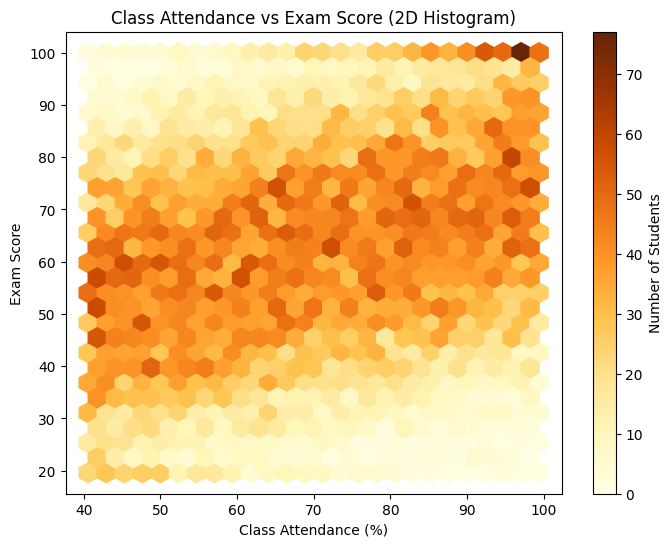

In [13]:
plt.figure(figsize=(8,6))
plt.hexbin(
    x=df['class_attendance'],
    y=df['exam_score'],
    gridsize=25,
     cmap='YlOrBr'
)
plt.xlabel("Class Attendance (%)")
plt.ylabel("Exam Score")
plt.title("Class Attendance vs Exam Score (2D Histogram)")
plt.colorbar(label='Number of Students')
plt.show()

In [14]:
df_prepared = df.copy()
df_prepared.select_dtypes(include="object").columns

Index(['gender', 'course', 'internet_access', 'sleep_quality', 'study_method',
       'facility_rating', 'exam_difficulty'],
      dtype='object')

In [15]:
df_prepared = df.copy()

df_prepared["sleep_quality"] = df_prepared["sleep_quality"].map({
    "poor": 1,
    "average": 2,
    "good": 3
})

df_prepared["exam_difficulty"] = df_prepared["exam_difficulty"].map({
    "easy": 1,
    "medium": 2,
    "hard": 3
})

df_prepared["facility_rating"] = df_prepared["facility_rating"].map({
    "low": 1,
    "medium": 2,
    "high": 3
})

df_prepared = pd.get_dummies(
    df_prepared,
    columns=["course", "study_method", "gender", "internet_access"],
    drop_first=True
)

corr = df_prepared.corr()["exam_score"].sort_values(ascending=False)

print(corr)

exam_score                    1.000000
study_hours                   0.717788
class_attendance              0.308850
sleep_quality                 0.198888
facility_rating               0.162923
sleep_hours                   0.133222
study_method_mixed            0.044980
course_bba                    0.008920
age                           0.006522
exam_difficulty               0.006377
course_b.sc                   0.004462
student_id                    0.003269
course_b.tech                 0.002993
gender_other                  0.001799
course_bca                    0.000236
course_diploma               -0.003917
gender_male                  -0.004342
internet_access_yes          -0.007826
course_ba                    -0.008727
study_method_group study     -0.040377
study_method_online videos   -0.063120
study_method_self-study      -0.101278
Name: exam_score, dtype: float64


In [16]:
df_prepared[
    ["study_hours", "class_attendance", "sleep_quality", "facility_rating", "sleep_hours"]
].corr()

,study_hours,class_attendance,sleep_quality,facility_rating,sleep_hours
study_hours,1.000000,-0.001645,-0.003493,-0.006144,-0.004533
class_attendance,-0.001645,1.000000,-0.007896,0.003939,0.007187
sleep_quality,-0.003493,-0.007896,1.000000,-0.002119,0.013813
facility_rating,-0.006144,0.003939,-0.002119,1.000000,-0.006989
sleep_hours,-0.004533,0.007187,0.013813,-0.006989,1.000000


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
from sklearn.model_selection import KFold, cross_val_score

In [18]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

In [19]:
features = [
    "study_hours",
    "class_attendance",
    "sleep_hours",
    "sleep_quality",
    "facility_rating"
]

X = df_prepared[features]
y = df_prepared["exam_score"]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


poly = PolynomialFeatures(degree=3, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)


scaler = StandardScaler()
X_train_poly_scaled = scaler.fit_transform(X_train_poly)
X_test_poly_scaled = scaler.transform(X_test_poly)


ridge = Ridge(alpha=1.0)
ridge.fit(X_train_poly_scaled, y_train)

y_pred = ridge.predict(X_test_poly_scaled)


print("R2:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))


cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(ridge, scaler.transform(poly.fit_transform(X)), y, cv=cv, scoring="r2")

print("\nCross-Validation R2 scores:", cv_scores)
print("Mean CV R2:", cv_scores.mean())
print("Std CV R2:", cv_scores.std())

NameError: name 'Ridge' is not defined

In [ ]:
from sklearn.neural_network import MLPRegressor

In [ ]:
features = [
    "study_hours",
    "class_attendance",
    "sleep_hours",
    "sleep_quality",
    "facility_rating",
    "study_method_self-study",
    "study_method_online videos",
    "study_method_group study",
    "study_method_mixed"
]

X = df_prepared[features]
y = df_prepared["exam_score"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

mlp = MLPRegressor(
    hidden_layer_sizes=(64, 32),   # 2 слоя
    activation="relu",
    solver="adam",
    alpha=0.001,                   # L2-регуляризация
    learning_rate_init=0.001,
    max_iter=2000,
    early_stopping=True,
    random_state=42
)

mlp.fit(X_train, y_train)


y_pred = mlp.predict(X_test)

print("R2:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

cv = KFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(
    mlp,
    X_scaled,
    y,
    cv=cv,
    scoring="r2",
    n_jobs=-1
)

print("\nCV R2 scores:", cv_scores)
print("Mean CV R2:", cv_scores.mean())
print("Std CV R2:", cv_scores.std())


R2: 0.7312623683223782
MAE: 7.903069626014088
RMSE: 9.804419892443029

CV R2 scores: [0.72995008 0.73619516 0.7236083  0.72249021 0.73007074]
Mean CV R2: 0.7284628982210499
Std CV R2: 0.004976442598604367


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

features = [
    "study_hours",
    "class_attendance",
    "sleep_hours",
    "sleep_quality",
    "facility_rating",
    "study_method_self-study",
    "study_method_online videos",
    "study_method_group study",
    "study_method_mixed"
]

X = df_prepared[features]
y = df_prepared["exam_score"]

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPRegressor(
        max_iter=3000,
        early_stopping=True,
        random_state=42
    ))
])

param_grid = {
    "mlp__hidden_layer_sizes": [(32,), (64,), (64, 32), (128, 64)],
    "mlp__alpha": [1e-4, 1e-3, 1e-2],
    "mlp__learning_rate_init": [1e-4, 1e-3],
    "mlp__activation": ["relu", "tanh"]
}

grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring="r2",
    n_jobs=-1
)

grid.fit(X, y)

print("Best R2:", grid.best_score_)
print("Best params:", grid.best_params_)

Best R2: 0.7304668504088683
Best params: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (32,), 'mlp__learning_rate_init': 0.001}


In [ ]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

features = [
    "study_hours",
    "class_attendance",
    "sleep_hours",
    "sleep_quality",
    "facility_rating",
    "study_method_self-study",
    "study_method_online videos",
    "study_method_group study",
    "study_method_mixed"
]


X = df_prepared[features]
y = df_prepared["exam_score"]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


model = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPRegressor(
        hidden_layer_sizes=(32,),
        activation="tanh",
        alpha=0.0001,
        learning_rate_init=0.001,
        max_iter=3000,
        early_stopping=True,
        random_state=42
    ))
])


model.fit(X_train, y_train)


y_pred = model.predict(X_test)

print("R2:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

cv_scores = cross_val_score(
    model, X, y, cv=5, scoring="r2", n_jobs=-1
)

print("CV R2:", cv_scores)
print("Mean CV R2:", cv_scores.mean())
print("Std CV R2:", cv_scores.std())


R2: 0.7323854102149523
MAE: 7.89483250329072
RMSE: 9.783912340749527
CV R2: [0.72117205 0.72032336 0.73036813 0.73922628 0.74124443]
Mean CV R2: 0.7304668504088683
Std CV R2: 0.008742737947876108


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

# --- Предположим, что df_prepared уже есть ---
features = [
    "study_hours",
    "class_attendance",
    "sleep_hours",
    "sleep_quality",
    "facility_rating",
    "study_method_self-study",
    "study_method_online videos",
    "study_method_group study",
    "study_method_mixed"
]

X = df_prepared[features].values
y = df_prepared["exam_score"].values.reshape(-1, 1)


scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42
)


X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)  
        )

    def forward(self, x):
        return self.net(x)

model = RegressionModel(input_dim=X_train.shape[1])


criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


epochs = 500
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')


model.eval()
with torch.no_grad():
    y_pred_scaled = model(X_test_tensor).numpy()
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_true = scaler_y.inverse_transform(y_test)

r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f'R2: {r2:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}')

Epoch [50/500], Loss: 0.3148
Epoch [100/500], Loss: 0.2690
Epoch [150/500], Loss: 0.2669
Epoch [200/500], Loss: 0.2655
Epoch [250/500], Loss: 0.2644
Epoch [300/500], Loss: 0.2635
Epoch [350/500], Loss: 0.2627
Epoch [400/500], Loss: 0.2620
Epoch [450/500], Loss: 0.2614
Epoch [500/500], Loss: 0.2608
R2: 0.7317, MAE: 7.8815, RMSE: 9.7955


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

# --- Предположим, что df_prepared уже есть ---
features = [
    "study_hours",
    "class_attendance",
    "sleep_hours",
    "sleep_quality",
    "facility_rating",
    "study_method_self-study",
    "study_method_online videos",
    "study_method_group study",
    "study_method_mixed"
]

X = df_prepared[features].values
y = df_prepared["exam_score"].values.reshape(-1, 1)


scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42
)


X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.net(x)

    def forward(self, x):
        return self.net(x)

model = RegressionModel(input_dim=X_train.shape[1])


criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


epochs = 5000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')


model.eval()
with torch.no_grad():
    y_pred_scaled = model(X_test_tensor).numpy()
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_true = scaler_y.inverse_transform(y_test)

r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f'R2: {r2:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}')

from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

r2_scores = []
mae_scores = []
rmse_scores = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(X_scaled)):
    print(f"\nFold {fold+1}")

    X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
    y_train, y_val = y_scaled[train_idx], y_scaled[val_idx]

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

    model = RegressionModel(input_dim=X_train.shape[1])
    criterion = nn.MSELoss()
    optimizer = optim.Adam(
        model.parameters(),
        lr=0.001,
        weight_decay=1e-4
    )

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', patience=20, factor=0.5
    )

    best_loss = np.inf
    patience = 40
    counter = 0

    for epoch in range(500):
        model.train()
        optimizer.zero_grad()

        output = model(X_train_tensor)
        loss = criterion(output, y_train_tensor)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_pred = model(X_val_tensor)
            val_loss = criterion(val_pred, y_val_tensor)

        scheduler.step(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            counter = 0
        else:
            counter += 1

        if counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    # Оценка
    model.eval()
    with torch.no_grad():
        y_val_pred_scaled = model(X_val_tensor).numpy()
        y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled)
        y_val_true = scaler_y.inverse_transform(y_val)

    r2_scores.append(r2_score(y_val_true, y_val_pred))
    mae_scores.append(mean_absolute_error(y_val_true, y_val_pred))
    rmse_scores.append(np.sqrt(mean_squared_error(y_val_true, y_val_pred)))

    print("\nCross-validation results:")
print(f"R2 mean:   {np.mean(r2_scores):.4f}")
print(f"MAE mean:  {np.mean(mae_scores):.4f}")
print(f"RMSE mean: {np.mean(rmse_scores):.4f}")

Epoch [50/5000], Loss: 0.3568
Epoch [100/5000], Loss: 0.3169
Epoch [150/5000], Loss: 0.3084
Epoch [200/5000], Loss: 0.3035
Epoch [250/5000], Loss: 0.2975
Epoch [300/5000], Loss: 0.2953
Epoch [350/5000], Loss: 0.2902
Epoch [400/5000], Loss: 0.2884
Epoch [450/5000], Loss: 0.2873
Epoch [500/5000], Loss: 0.2863
Epoch [550/5000], Loss: 0.2842
Epoch [600/5000], Loss: 0.2833
Epoch [650/5000], Loss: 0.2818
Epoch [700/5000], Loss: 0.2822
Epoch [750/5000], Loss: 0.2787
Epoch [800/5000], Loss: 0.2795
Epoch [850/5000], Loss: 0.2783
Epoch [900/5000], Loss: 0.2787
Epoch [950/5000], Loss: 0.2775
Epoch [1000/5000], Loss: 0.2749
Epoch [1050/5000], Loss: 0.2747
Epoch [1100/5000], Loss: 0.2749
Epoch [1150/5000], Loss: 0.2736
Epoch [1200/5000], Loss: 0.2742
Epoch [1250/5000], Loss: 0.2734
Epoch [1300/5000], Loss: 0.2727
Epoch [1350/5000], Loss: 0.2718
Epoch [1400/5000], Loss: 0.2717
Epoch [1450/5000], Loss: 0.2724
Epoch [1500/5000], Loss: 0.2705
Epoch [1550/5000], Loss: 0.2711
Epoch [1600/5000], Loss: 0.2

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

features = [
    "study_hours",
    "class_attendance",
    "sleep_hours",
    "sleep_quality",
    "facility_rating",
    "study_method_self-study",
    "study_method_online videos",
    "study_method_group study",
    "study_method_mixed"
]

X = df_prepared[features].values
y = df_prepared["exam_score"].values.reshape(-1, 1)


scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42
)


X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LayerNorm(128),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.LayerNorm(64),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),

            nn.Linear(64, 32),
            nn.LayerNorm(32),
            nn.LeakyReLU(0.1),

            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

model = RegressionModel(input_dim=X_train.shape[1])


criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


epochs = 10000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')


model.eval()
with torch.no_grad():
    y_pred_scaled = model(X_test_tensor).numpy()
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_true = scaler_y.inverse_transform(y_test)

r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f'R2: {r2:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}')

from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

r2_scores = []
mae_scores = []
rmse_scores = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(X_scaled)):
    print(f"\nFold {fold+1}")

    X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
    y_train, y_val = y_scaled[train_idx], y_scaled[val_idx]

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

    model = RegressionModel(input_dim=X_train.shape[1])
    criterion = nn.MSELoss()
    optimizer = optim.Adam(
        model.parameters(),
        lr=0.001,
        weight_decay=1e-4
    )

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', patience=20, factor=0.5
    )

    best_loss = np.inf
    patience = 40
    counter = 0

    for epoch in range(500):
        model.train()
        optimizer.zero_grad()

        output = model(X_train_tensor)
        loss = criterion(output, y_train_tensor)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_pred = model(X_val_tensor)
            val_loss = criterion(val_pred, y_val_tensor)

        scheduler.step(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            counter = 0
        else:
            counter += 1

        if counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    model.eval()
    with torch.no_grad():
        y_val_pred_scaled = model(X_val_tensor).numpy()
        y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled)
        y_val_true = scaler_y.inverse_transform(y_val)

    r2_scores.append(r2_score(y_val_true, y_val_pred))
    mae_scores.append(mean_absolute_error(y_val_true, y_val_pred))
    rmse_scores.append(np.sqrt(mean_squared_error(y_val_true, y_val_pred)))

    print("\nCross-validation results:")
print(f"R2 mean:   {np.mean(r2_scores):.4f}")
print(f"MAE mean:  {np.mean(mae_scores):.4f}")
print(f"RMSE mean: {np.mean(rmse_scores):.4f}")

Epoch [100/10000], Loss: 0.3046
Epoch [200/10000], Loss: 0.2902
Epoch [300/10000], Loss: 0.2841
Epoch [400/10000], Loss: 0.2809
Epoch [500/10000], Loss: 0.2778
Epoch [600/10000], Loss: 0.2743
Epoch [700/10000], Loss: 0.2737
Epoch [800/10000], Loss: 0.2719
Epoch [900/10000], Loss: 0.2716
Epoch [1000/10000], Loss: 0.2710
Epoch [1100/10000], Loss: 0.2685
Epoch [1200/10000], Loss: 0.2686
Epoch [1300/10000], Loss: 0.2695
Epoch [1400/10000], Loss: 0.2685
Epoch [1500/10000], Loss: 0.2672
Epoch [1600/10000], Loss: 0.2669
Epoch [1700/10000], Loss: 0.2666
Epoch [1800/10000], Loss: 0.2654
Epoch [1900/10000], Loss: 0.2661
Epoch [2000/10000], Loss: 0.2648
Epoch [2100/10000], Loss: 0.2649
Epoch [2200/10000], Loss: 0.2645
Epoch [2300/10000], Loss: 0.2640
Epoch [2400/10000], Loss: 0.2633
Epoch [2500/10000], Loss: 0.2647
Epoch [2600/10000], Loss: 0.2636
Epoch [2700/10000], Loss: 0.2635
Epoch [2800/10000], Loss: 0.2624
Epoch [2900/10000], Loss: 0.2630
Epoch [3000/10000], Loss: 0.2628
Epoch [3100/10000],

In [23]:
import numpy as np
import torch
import torch.nn as nn


# ====== DEVICE ======
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# ====== DATA (numpy -> torch) ======
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1).to(device)

X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).view(-1).to(device)


# ====== MODEL ======
class ResidualBlock(nn.Module):
    def __init__(self, dim, dropout=0.1):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(dim, dim),
            nn.LayerNorm(dim),
            nn.LeakyReLU(0.1),
            nn.Dropout(dropout),
            nn.Linear(dim, dim)
        )

    def forward(self, x):
        return x + self.block(x)


class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()

        self.input_layer = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LayerNorm(128),
            nn.LeakyReLU(0.1)
        )

        self.res_block1 = ResidualBlock(128, dropout=0.2)
        self.res_block2 = ResidualBlock(128, dropout=0.2)

        self.hidden = nn.Sequential(
            nn.Linear(128, 64),
            nn.LayerNorm(64),
            nn.LeakyReLU(0.1)
        )

        self.output_layer = nn.Linear(64, 1)

    def forward(self, x):
        x = self.input_layer(x)
        x = self.res_block1(x)
        x = self.res_block2(x)
        x = self.hidden(x)
        return self.output_layer(x)


model = RegressionModel(input_dim=X_train.shape[1]).to(device)


# ====== LOSS & OPTIMIZER ======
criterion = nn.SmoothL1Loss()

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-3,
    weight_decay=1e-4
)


# ====== TRAIN / VAL STEPS ======
def train_step(model, optimizer, criterion, x, y):
    model.train()
    optimizer.zero_grad()
    preds = model(x)
    loss = criterion(preds.squeeze(), y)
    loss.backward()
    optimizer.step()
    return loss.item()


@torch.no_grad()
def val_step(model, criterion, x, y):
    model.eval()
    preds = model(x)
    loss = criterion(preds.squeeze(), y)
    return loss.item()


# ====== TRAIN LOOP ======
EPOCHS = 500

for epoch in range(1, EPOCHS + 1):
    train_loss = train_step(model, optimizer, criterion, X_train, y_train)
    val_loss = val_step(model, criterion, X_val, y_val)

    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d} | Train: {train_loss:.4f} | Val: {val_loss:.4f}")

    r2_scores.append(r2_score(y_val_true, y_val_pred))
    mae_scores.append(mean_absolute_error(y_val_true, y_val_pred))
    rmse_scores.append(np.sqrt(mean_squared_error(y_val_true, y_val_pred)))

print("\nCross-validation results:")
print(f"R2 mean:   {np.mean(r2_scores):.4f}")
print(f"MAE mean:  {np.mean(mae_scores):.4f}")
print(f"RMSE mean: {np.mean(rmse_scores):.4f}")



ValueError: could not determine the shape of object type 'DataFrame'

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda
